In [1]:
import syft as sy
import torch
from tools import models
import numpy as np
import pandas as pd
import time

sy.load('opacus')
np.random.seed(42) # The meaning of life!

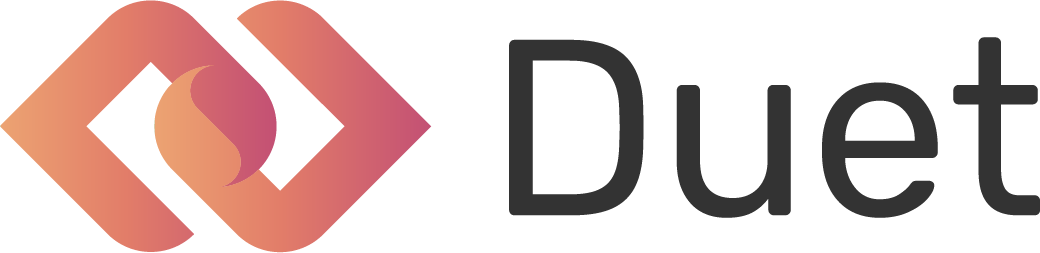

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet(loopback=True)

In [3]:
# Getting the pionters to the data
time.sleep(31) # Sleep timer so you can just press restart on both notebooks without caring (might need to be adjusted)

train_data_ptr = duet.store[0]
train_labels_ptr = duet.store[1]

test_data_ptr = duet.store[2]
test_labels_ptr = duet.store[3]

In [4]:
# Constants for tracking purposes
MODEL = 'Deep2DNet'
DATASET = 'MedNIST'
TRACKING = True # Whether or not this run should be tracked in the results csv file
DP = False # Whether or not Differential Privacy should be applied

# Parameters for training and Differential Privacy
BATCH_SIZE = 100
EPOCHS = 30
LEARNING_RATE = 0.002 if DP else 0.001

DELTA = 1e-4 # Set to be less then the inverse of the size of the training dataset (from https://opacus.ai/tutorials/building_image_classifier)
NOISE_MULTIPLIER = 2.0 # The amount of noise sampled and added to the average of the gradients in a batch (from https://opacus.ai/tutorials/building_image_classifier)
MAX_GRAD_NORM = 1.0 # The maximum L2 norm of per-sample gradients before they are aggregated by the averaging step (from https://opacus.ai/tutorials/building_image_classifier)

length = len(train_data_ptr)
SAMPLE_SIZE = length - length % BATCH_SIZE # NOTE: Current implementation only trains data in multiples of batch size. So BATCH_SIZE % LENGTH amount of data will not be used for training.
SAMPLE_RATE = BATCH_SIZE / SAMPLE_SIZE

In [5]:
# Getting remote and local instances
local_model = models.Deep2DNet(torch)
remote_model = local_model.send(duet)
remote_torch = duet.torch
remote_opacus = duet.opacus

# Setting device to train on
cuda_available = remote_torch.cuda.is_available().get(request_block=True, reason='Need to check for available GPU!')
if cuda_available:
    device = remote_torch.device('cuda:0')
    remote_model.cuda(device)
else:
    device = remote_torch.device('cpu')
    remote_model.cpu()

# Optimizer and Loss Function
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=LEARNING_RATE)
loss_function = remote_torch.nn.CrossEntropyLoss()

# Setting up Differential Privacy Engine
if DP:
    privacy_engine_ptr = remote_opacus.privacy_engine.PrivacyEngine(
        remote_model.real_module, sample_rate=SAMPLE_RATE,
        noise_multiplier=NOISE_MULTIPLIER, max_grad_norm=MAX_GRAD_NORM
    )
    privacy_engine_ptr.to(device)
    privacy_engine_ptr.attach(optim)
else:
    privacy_engine_ptr = None


In [6]:
from tools.utils import train, test

losses, test_accs, test_losses, epsilons, alphas, epoch_times = train(BATCH_SIZE, EPOCHS, DELTA, 
                                                                      remote_model, remote_torch,
                                                                      optim, loss_function, 
                                                                      train_data_ptr, train_labels_ptr, 
                                                                      test_data_ptr, test_labels_ptr, 
                                                                      [1, 64, 64], device, privacy_engine_ptr)

###### Epoch 1 ######
Training Loss: 1.7917022705078125
Training Loss: 1.7867822647094727
Training Loss: 1.792954683303833
Training Loss: 1.7914577722549438
Training Loss: 1.7858389616012573
Training Loss: 1.7849044799804688
Training Loss: 1.7797846794128418
Training Loss: 1.773114800453186
Training Loss: 1.7783865928649902
Training Loss: 1.758459210395813
Training Loss: 1.7346696853637695
Training Loss: 1.7244961261749268
Training Loss: 1.6506494283676147
Training Loss: 1.6024868488311768
Training Loss: 1.590328335762024
Training Loss: 1.6124099493026733
Training Loss: 1.4811921119689941
Training Loss: 1.4070463180541992
Test Accuracy: 0.5728155374526978 ---- Test Loss: 1.3640081882476807
Epoch time: 6.446895599365234 seconds
###### Epoch 2 ######
Training Loss: 1.4996532201766968
Training Loss: 1.2566636800765991
Training Loss: 1.2250947952270508
Training Loss: 1.1630462408065796
Training Loss: 1.1955317258834839
Training Loss: 1.0501824617385864
Training Loss: 0.9013252258300781
Tra

In [7]:
from tools import datasets
# TODO!: Use best model for validation
# Sadly very redundant since remotly tracking best model is not easily possible and therefore just last model is used for validation
# Evalutating the model locally with the validation data
eval_model = remote_model.get(request_block=True, reason="Needed for local evaluation!")
eval_model.cuda(torch.device('cuda:0'))
loss_function = torch.nn.CrossEntropyLoss()

# Higher sample_size here as on DO side will ensure that it is actually data that is not in train or test set!
_, _, val_ds = datasets.Loader.load_MedNIST(sample_size=0.1, test_size=0.1, val_size=0.05)
val_data, val_labels = val_ds.as_tensor()

val_acc, val_loss = test(eval_model, loss_function, torch, val_data, val_labels, torch.device('cuda:0'))

print(f'Validation Accuracy: {val_acc} ---- Validation Loss: {val_loss}')

Validation Accuracy: 0.9013605442176871 ---- Validation Loss: 0.3175201714038849


In [8]:
# Tracking all interesting variables and results in .csv file
if TRACKING:
    d = {
        'model': MODEL,
        'dataset': DATASET,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'train_sample_size': SAMPLE_SIZE,
        'test_sample_size': len(test_data_ptr),
        'val_sample_size': len(val_data),
        'delta': DELTA,
        'noise_multiplier': NOISE_MULTIPLIER,
        'max_grad_norm': MAX_GRAD_NORM,
        'dp_used': DP,
        'epsilons': epsilons,
        'alphas': alphas,
        'train_losses': losses,
        'test_accs': test_accs,
        'test_losses': test_losses,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'epoch_times': epoch_times
    }      
    df = pd.read_csv('./Results/1DO-1DS.csv')
    df = df.append(d, ignore_index=True)
    df.to_csv('./Results/1DO-1DS.csv', index=False)